In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
print(len(tf.config.experimental.list_physical_devices('GPU')))

0


In [ ]:
tf.test.is_built_with_cuda()

True

In [ ]:
print(tf.version.VERSION)

2.9.2


In [ ]:
import sys 
sys.version

'3.7.15 (default, Oct 12 2022, 19:14:55) \n[GCC 7.5.0]'

In [ ]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from tensorflow.keras.utils import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [ ]:
with tf.device("/gpu:1"):   
    gray_img = []
    def sorted_alphanumeric(data):  
        convert = lambda text: int(text) if text.isdigit() else text.lower()
        alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
        return sorted(data,key = alphanum_key)
    SIZE = 160
    path = '/content/drive/MyDrive/chest_xray_new_again/train/PNEUMONIA'
    files = os.listdir(path)
    files = sorted_alphanumeric(files)
    for i in tqdm(files):
        if i == '6000.jpg':
            break
        else: 
            img = cv2.imread(path + '/'+i,1)

            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = img.astype('float32') / 255.0
            gray_img.append(img_to_array(img))

100%|██████████| 400/400 [00:06<00:00, 60.98it/s]


In [ ]:
# defining function to plot images
def plot_images(grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
   
    plt.show()

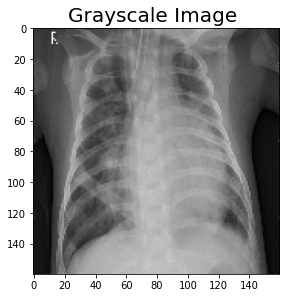

In [ ]:
plot_images(gray_img[8])

In [ ]:
len(gray_img)

400

In [ ]:
train_gray_image = gray_img[:200] #5500
# train_color_image = color_img[:500] #5500

test_gray_image = gray_img[200:] #5500
# test_color_image = color_img[500:] #5500

with tf.device("/gpu:1"):
    # reshaping
    train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
    # train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
    print('Train image shape:',train_g.shape)
    test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
    # test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
    print('Test image shape',test_gray_image.shape)

Train image shape: (200, 160, 160, 3)
Test image shape (200, 160, 160, 3)


In [ ]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [ ]:
def model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    d5 = down(512,(3,3),True)(d4)
    
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [ ]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 80, 80, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 40, 40, 128)  147584      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 20, 20, 256)  296192      ['sequential_1[0][0]']       

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error')

In [ ]:

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(train_g, test_gray_image)

In [ ]:
len(train_g)

200

In [ ]:
auto=model.fit(X_train, y_train, epochs = 10,batch_size = 50,verbose = 1,validation_data=[X_test,y_test])

Epoch 1/10
3/3 [==============================] - 49s 17s/step - loss: 0.4562 - val_loss: 0.3256
Epoch 2/10
3/3 [==============================] - 44s 16s/step - loss: 0.3249 - val_loss: 0.2913
Epoch 3/10
3/3 [==============================] - 43s 16s/step - loss: 0.2338 - val_loss: 0.1978
Epoch 4/10
3/3 [==============================] - 43s 16s/step - loss: 0.2113 - val_loss: 0.2085
Epoch 5/10
3/3 [==============================] - 45s 17s/step - loss: 0.1901 - val_loss: 0.2284
Epoch 6/10
3/3 [==============================] - 42s 15s/step - loss: 0.1754 - val_loss: 0.2244
Epoch 7/10
3/3 [==============================] - 47s 16s/step - loss: 0.1631 - val_loss: 0.2078
Epoch 8/10
3/3 [==============================] - 44s 16s/step - loss: 0.1520 - val_loss: 0.2151
Epoch 9/10
3/3 [==============================] - 46s 17s/step - loss: 0.1447 - val_loss: 0.1781
Epoch 10/10
3/3 [==============================] - 44s 15s/step - loss: 0.1410 - val_loss: 0.1686


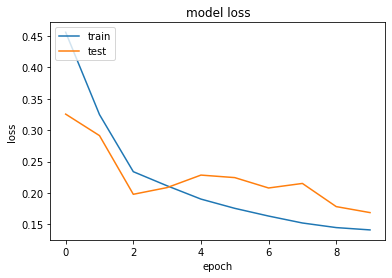

In [ ]:
plt.plot(auto.history['loss'])
plt.plot(auto.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(test_gray_image)

7/7 [==============================] - 0s 5ms/step - loss: 0.0000e+00


0.0

In [ ]:
# defining function to plot images pair
def plot_images(grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

1/1 [==============================] - 0s 263ms/step


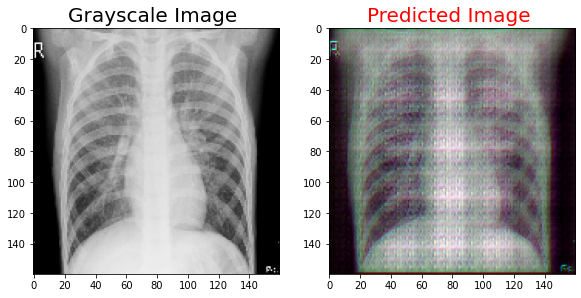

1/1 [==============================] - 0s 172ms/step


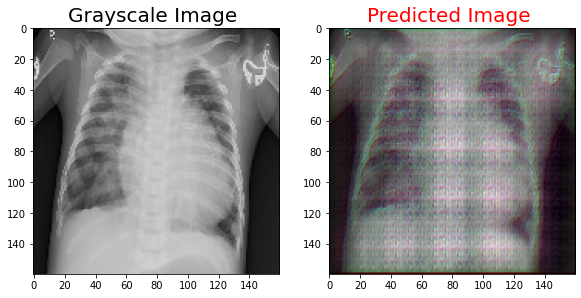

1/1 [==============================] - 0s 124ms/step


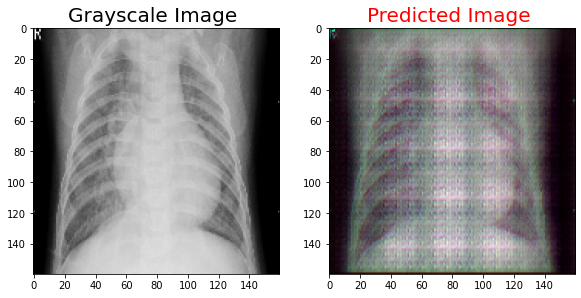

1/1 [==============================] - 0s 164ms/step


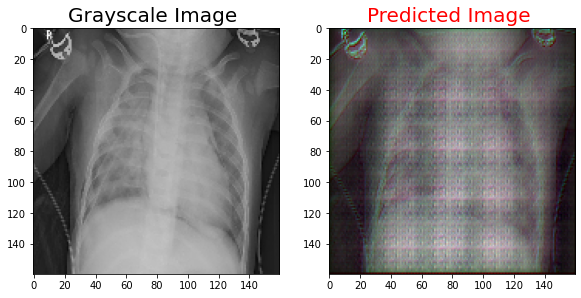

In [ ]:
for i in range(21,25):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_gray_image[i],predicted)